In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
data_path = r'E:\Datasets\Language Translation\spa-eng\spa.txt'
num_examples = 60000
batch_size = 64
train_size = 0.8
embedding_dim = 1024
num_heads = 8
d_model = 1024
dff = 2048
dropout_rate = 0.1
num_encoder = 6
num_decoder = 6

In [3]:
def preprocess_data(sentence):
    sentence = sentence.lower()
    sentence = re.sub(' +', ' ', sentence)
    sentence = re.sub("'", '', sentence)
    sentence = re.sub(r'([?,;.¿!])', r' \1 ', sentence)
    sentence = 'start_ ' + sentence + ' _end'
    return sentence

In [4]:
def load_data(path, num_examples):
    df = pd.read_table(path, names = ['Source', 'Target', 'Comment']).dropna()[:num_examples]
    
    source = [preprocess_data(src) for src in df['Source']]
    target = [preprocess_data(tar) for tar in df['Target']]
    return source, target

In [5]:
source, target = load_data(data_path, num_examples)

In [6]:
source_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters = '')
source_tokenizer.fit_on_texts(source)
source_token = source_tokenizer.texts_to_sequences(source)

In [7]:
target_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters = '')
target_tokenizer.fit_on_texts(target)
target_token = target_tokenizer.texts_to_sequences(target)

In [8]:
source_vocab_size = len(source_tokenizer.word_index) + 1
target_vocab_size = len(target_tokenizer.word_index) + 1

In [9]:
source_tensor = tf.keras.preprocessing.sequence.pad_sequences(source_token, padding = 'post')
target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_token, padding = 'post')

In [10]:
source_tensor.shape, target_tensor.shape

((60000, 12), (60000, 16))

In [11]:
dataset = tf.data.Dataset.from_tensor_slices((source_tensor, target_tensor))\
.shuffle(num_examples).batch(batch_size, drop_remainder = True)

In [12]:
train_dataset = dataset.take(round(len(dataset) * train_size))
val_dataset = dataset.skip(len(train_dataset))

In [13]:
sample_source, sample_target = next(iter(dataset))

In [14]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        pass
    
    def build(self, input_shape):
        n, d = input_shape[1:]
        
        self.pe = np.empty((1, n, d))
        encoded = np.arange(n).reshape(n, 1) @ (1/(10000**(2*np.arange(d//2)/d))).reshape(1, d//2)
        self.pe[:, :, ::2] = np.sin(encoded)
        self.pe[:, :, 1::2] = np.cos(encoded)
        
        self.pe = tf.cast(self.pe, tf.float32)
        
    def call(self, inputs):
        return inputs + self.pe

In [15]:
pe = PositionalEncoding()(tf.zeros((1, 2048, 512)))

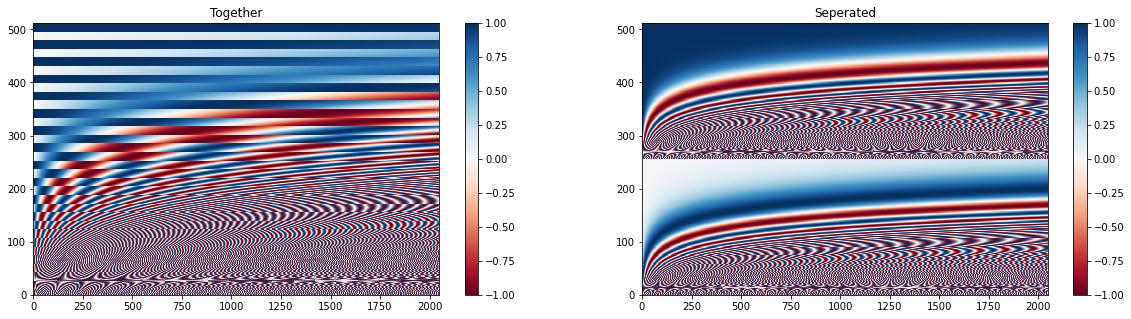

In [16]:
plt.figure(figsize = (20, 5))

plt.subplot(121)
plt.pcolormesh(pe[0].numpy().T, cmap = 'RdBu')
plt.title('Together')
plt.colorbar()

plt.subplot(122)
plt.pcolormesh(np.concatenate([pe[0][:, ::2], pe[0][:, 1::2]], axis = -1).T, cmap = 'RdBu')
plt.title('Seperated')
plt.colorbar()

plt.show()

In [17]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads, d_model, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.d_model = d_model
        self.depth = d_model // num_heads
        
        assert d_model%num_heads == 0
        
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.wo = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, h):
        x = tf.reshape(h, (h.shape[0], -1, self.num_heads, self.depth))
        return tf.transpose(x, perm = [0, 2, 1, 3])
        
    def self_attention(self, q, k, v, mask):
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        
        score = tf.matmul(q, k, transpose_b = True) * tf.math.rsqrt(dk)
        if mask is not None:
            score += (mask * -1e9)
            
        attention_weights = tf.nn.softmax(score, axis = -1)
        out = tf.matmul(attention_weights, v)
        return out, attention_weights
        
    def call(self, q, k, v, mask):
        q = self.split_heads(self.wq(q))
        k = self.split_heads(self.wk(k))
        v = self.split_heads(self.wv(v))
        
        out, attention_weights = self.self_attention(q, k, v, mask)
        out = tf.concat([out[:, i, :, :] for i in range(self.num_heads)], axis = -1)
        out = self.wo(out)
        
        return out, attention_weights

In [18]:
class PointWiseFeedForwardNetwork(tf.keras.layers.Layer):
    def __init__(self, dff, d_model, **kwargs):
        super().__init__(**kwargs)
        self.ffn1 = tf.keras.layers.Dense(dff, activation = 'relu')
        self.ffn2 = tf.keras.layers.Dense(d_model)
        
    def call(self, inputs):
        return self.ffn2(self.ffn1(inputs))

In [19]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, num_heads, d_model, dff, dropout_rate, **kwargs):
        super().__init__(**kwargs)
        self.mha = MultiHeadAttention(num_heads, d_model)
        self.dropout_1 = tf.keras.layers.Dropout(dropout_rate)
        self.layernorm_1 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        
        self.ffn = PointWiseFeedForwardNetwork(dff, d_model)
        self.dropout_2 = tf.keras.layers.Dropout(dropout_rate)
        self.layernorm_2 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        
    def call(self, x, training, mask):
        x1, _ = self.mha(x, x, x, mask)
        x1 = self.dropout_1(x1, training = training)
        x1 = self.layernorm_1(x + x1)
        
        x2 = self.ffn(x1)
        x2 = self.dropout_2(x2, training = training)
        x2 = self.layernorm_2(x1 + x2)
        return x2

In [20]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, num_heads, d_model, dff, dropout_rate, enc_num , **kwargs):
        super().__init__(**kwargs)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.pe = PositionalEncoding()
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        
        self.encoder_layers = [EncoderLayer(num_heads, d_model, dff, dropout_rate) for _ in range(enc_num)]
        
    def call(self, x, training, mask):
        x = self.dropout(self.pe(self.embedding(x)), training = training)
        
        for layer in self.encoder_layers:
            x = layer(x, training, mask)
        return x

In [21]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, num_heads, d_model, dff, dropout_rate, **kwargs):
        super().__init__(**kwargs)
        self.masked_mha = MultiHeadAttention(num_heads, d_model)
        self.dropout_1 = tf.keras.layers.Dropout(dropout_rate)
        self.layernorm_1 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        
        self.mha = MultiHeadAttention(num_heads, d_model)
        self.dropout_2 = tf.keras.layers.Dropout(dropout_rate)
        self.layernorm_2 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        
        self.ffn = PointWiseFeedForwardNetwork(dff, d_model)
        self.dropout_3 = tf.keras.layers.Dropout(dropout_rate)
        self.layernorm_3 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        
    def call(self, x, enc_k, enc_v, training, mask_1, mask_2):
        
        x1, _ = self.masked_mha(x, x, x, mask_1)
        x1 = self.dropout_1(x1, training = training)
        x1 = self.layernorm_1(x + x1)
        
        x2, _ = self.mha(x1, enc_k, enc_v, mask_2)
        x2 = self.dropout_2(x2, training = training)
        x2 = self.layernorm_2(x1 + x2)
        
        x3 = self.ffn(x2)
        x3 = self.dropout_3(x3, training = training)
        x3 = self.layernorm_3(x2 + x3)
        return x3

In [22]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, num_heads, d_model, dff, dropout_rate, dec_num, **kwargs):
        super().__init__(**kwargs)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.pe = PositionalEncoding()
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        
        self.decoder_layers = [DecoderLayer(num_heads, d_model, dff, dropout_rate) for _ in range(dec_num)]
        
    def call(self, x, enc_k, enc_v, training, mask_1, mask_2):
        x = self.dropout(self.pe(self.embedding(x)), training = training)
        
        for layer in self.decoder_layers:
            x = layer(x, enc_k, enc_v, training, mask_1, mask_2)
        return x

In [23]:
class Transformer(tf.keras.models.Model):
    def __init__(self, source_vocab_size, target_vocab_size, embedding_dim, num_heads, d_model, dff, dropout_rate, 
                 enc_num, dec_num, **kwargs):
        super().__init__(**kwargs)
        self.encoder = Encoder(source_vocab_size, embedding_dim, num_heads, d_model, dff, dropout_rate, enc_num)
        self.decoder = Decoder(target_vocab_size, embedding_dim, num_heads, d_model, dff, dropout_rate, dec_num)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
        
    def call(self, x, training):
        inp, tar = x
        
        enc_pad_mask = self.get_pad_mask(inp)
        dec_pad_mask = self.get_pad_mask(inp)
        look_ahead_mask = tf.maximum(self.get_look_ahead_mask(tar.shape[-1]), self.get_pad_mask(tar))
        
        enc_out = self.encoder(inp, training, enc_pad_mask)
        dec_out = self.decoder(tar, enc_out, enc_out, training, look_ahead_mask, dec_pad_mask)
        out = self.final_layer(dec_out)
        return out
    
    def get_look_ahead_mask(self, size):
        return tf.convert_to_tensor(np.triu(np.ones((size, size)), k = 1), dtype = tf.float32)
    
    def get_pad_mask(self, seq):
        return tf.cast(tf.math.equal(seq, 0), tf.float32)[:, tf.newaxis, tf.newaxis, :]

In [24]:
transformer = Transformer(source_vocab_size, target_vocab_size, embedding_dim, num_heads, d_model, dff, dropout_rate, 
                          num_encoder, num_decoder)

In [25]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_step = 4000, **kwargs):
        super().__init__(**kwargs)
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_step = warmup_step
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_step ** -1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.minimum(arg1, arg2)
    
optimizer = tf.keras.optimizers.Adam(learning_rate = CustomSchedule(d_model = 1024), beta_1 = 0.98)

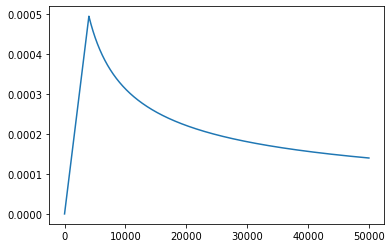

In [26]:
plt.plot(CustomSchedule(1024)(np.arange(50000).astype(np.float32)));

In [27]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, loss_.dtype)
    loss_ *= mask
    return tf.math.reduce_sum(loss_) / tf.math.reduce_sum(mask)

In [28]:
@tf.function
def train_step(inp, tar):
    
    tar_inp = tar[:, :-1]
    tar_real = tar[: , 1:]
    with tf.GradientTape() as tape:
        pred = transformer([inp, tar_inp], training = True)
        loss = loss_function(tar_real, pred)
    batch_loss = loss/tar_real.shape[-1]    
    grads = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(grads, transformer.trainable_variables))
    
    return batch_loss

In [29]:
def train(data, epochs = 1):
    losses = []
    for e in range(epochs):
        loss = 0
        print(f'Epoch {e} Starts\n')
        for batch, (inp, tar) in enumerate(data):
            batch_loss = train_step(inp, tar)
            loss += batch_loss
            
            losses.append(batch_loss)
            if batch%100 == 0:
                print(f'Batch: {batch} \t Loss: {batch_loss}')
                
        loss/=len(data)
        print(f'\nEpoch: {e} \t Loss: {loss}')
        print(f'Epoch {e} Ends\n\n\n')
        
    return losses

In [30]:
EPOCHS = 1
losses = train(train_dataset, epochs = EPOCHS)

Epoch 0 Starts

Batch: 0 	 Loss: 0.6479597091674805
Batch: 100 	 Loss: 0.47898590564727783
Batch: 200 	 Loss: 0.40838369727134705
Batch: 300 	 Loss: 0.36777421832084656
Batch: 400 	 Loss: 0.3604050874710083
Batch: 500 	 Loss: 0.3714190125465393
Batch: 600 	 Loss: 0.37167027592658997
Batch: 700 	 Loss: 0.35462766885757446

Epoch: 0 	 Loss: 0.40292221307754517
Epoch 0 Ends





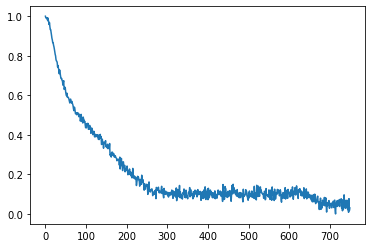

In [31]:
l = (losses - np.min(losses))/(np.max(losses) - np.min(losses))
plt.plot(l)
plt.show()